In [ ]:
!pip install pyopencl

import sys 
sys.path.append('/usr/local/lib/python3.6/site-packages')
import pyopencl as cl
import pyopencl.array as cl_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#Kernel

Se hace partición del espacio de salida, ya que para la función ROT algunos pixeles del espacio de entrada no podrían ser mapeados al espacio de salida sin salirse del rango de la matriz/imagen. A su vez hay pixeles de la imagen resultante que deben quedar en blanco, esto puede hacerse asignando un thread a cada elemento del espacio de salida.

También, debido a la naturaleza del problema, cada pixel del espacio de entrada no se mapeará necesariamente a un unico pixel en el espacio de salida. Este problema puede ser resuelto usando "nearest neighbor interpolation" o en nuestro caso haciendo un casteo del valor float de la posicion.

Si se usara particion de la entrada, varios workitems podrian intentar escribir la misma posición en la salida y podría haber pixeles de la salida sin valor debido a que no tienen correspondencia directa con un pixel de entrada.

In [21]:
KernelSource = """
__kernel void EV(
  const int M,
  const int N,
  __global const int *a_g,
  __global int *res_g)
  {
    int i = get_global_id(0);
    int j = get_global_id(1);

    int newposition = (N-1) - j;
    res_g[j*M + i] = a_g[newposition*M + i];
  }

  __kernel void EH(
  const int M,
  const int N,
  __global const int *a_g,
  __global int *res_g)
  {
    int i = get_global_id(0);
    int j = get_global_id(1);

    int newposition = (M-1) - i;
    res_g[j*M + i] = a_g[j*M + newposition];
  }

  __kernel void ROT(
  const int M,
  const int N,
  const int cx,
  const int cy,
  const float angle,
  __global const int *a_g,
  __global int *res_g)
  {
    int i = get_global_id(0);
    int j = get_global_id(1);

    float inv_angle = -angle;
    float zeta = (M_PI_F * inv_angle)/180;

    float arg_a = cos(zeta);
    float arg_b = sin(zeta);
    int fx = arg_a*(i-cx) - arg_b*(j-cy) + cx;
    int fy = arg_b*(i-cx) + arg_a*(j-cy) + cy;
    int newposition = fy*M + fx;


    if ((newposition >= 0) && (newposition < (M*N) )) {
      res_g[j*M + i] = a_g[newposition];
    } else {
      res_g[j*M + i] = a_g[0];
    }
  }
"""
#      res_g[j*M + i] = 255;
#      res_g[j*M + i] = a_g[0];

ROT hace la rotacion en el angulo inverso para hacer el calculo de la posicion del pixel correspondiente a res_g[i][j] desde la posicion i y j de la salida.

El angulo se pasa a radianes antes de calcular seno y coseno.

Luego de calcular la posicion del pixel en la entrada verifico si esta dentro del rango de la imagen. Si está fuera del rango lo pinto en blanco. 

No estaba seguro como pintar un pixel en blanco desde el kernel escrito en c.

Mi código original lo escribia res_g[j*M + i] = a_g[0]. Lo cual funciona porque el primer pixel de nuestra imagen de entrada particular es un pixel en blanco, pero esto es obviamente incorrecto.

# Input

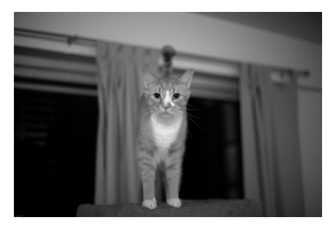

231
340


In [22]:
#Definitions of the size of the matrix and the number of iterations to run
P = ['EV','EH',['ROT', 300, 300, 56.3], 'EH']

img = Image.open("input.png")
data = np.asarray(img)

fig, ax = plt.subplots()
ax.imshow(data,cmap='gray')
plt.axis('off')
plt.show()

height = img.height
width = img.width

print(height)
print(width)

#Host

In [ ]:
data_np = data
size = width * height

# Obtener la plataforma
plataform_list = cl.get_platforms()

# Obtener los dispositivos
devices = plataform_list[0].get_devices(device_type = cl.device_type.GPU)

# Crear el contexto
context = cl.Context(devices=devices)

# Crear el Command Queue
queue = cl.CommandQueue(context, properties = cl.command_queue_properties.PROFILING_ENABLE | cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE)

# Crear e inicializar las matrices de entrada
a_np = np.arange(size).astype(np.float32)
b_np = np.arange(size).astype(np.float32)

# Crear e inicializar el vector de salida
res_np = np.empty_like(data)

# Crear e inicializar los Buffers (OpenCL)
datai_g = cl.Buffer(context, cl.mem_flags.READ_WRITE | cl.mem_flags.COPY_HOST_PTR, hostbuf = data_np)

# Crear buffer de salida (OpenCL)
res_g = cl.Buffer(context, cl.mem_flags.READ_WRITE, res_np.nbytes)

# Crear el programa
program = cl.Program(context, KernelSource).build()

# Crear los kernels y configurar los argumentos
kernelEV = program.EV
kernelEV.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

kernelEH = program.EH
kernelEH.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

kernelROT = program.ROT
kernelROT.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.float32, None, None])

# Definir el espacio indexado
globalRange = (width,height)
localRange = None

# Ejecutar el kernel
swap = datai_g
dest = res_g

for i in P:
  print(i)
  if i == "EV":
    kernelEV.set_args(width, height, swap, dest)
    eventev = cl.enqueue_nd_range_kernel(queue, kernelEV, globalRange, localRange)
    eventev.wait()
  elif i == "EH":
    kernelEH.set_args(width, height, swap, dest)
    eventeh = cl.enqueue_nd_range_kernel(queue, kernelEH, globalRange, localRange)
    eventeh.wait()
  else:
    if len(i) >= 3:
      if i[0] == "ROT":
        cx = i[1]
        cy = i[2]
        ang = i[3]
        kernelROT.set_args(width, height, cx, cy, ang, swap, dest)
        eventrot = cl.enqueue_nd_range_kernel(queue, kernelROT, globalRange, localRange)
        eventrot.wait()
    else:
      print("Invalid input.")
  swap = dest
  dest = swap

# Copy result del device al host
cl.enqueue_copy(queue, res_np, swap)

# Output

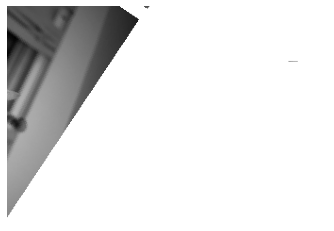

In [24]:
fig1, ax1 = plt.subplots()
ax1.imshow(res_np,cmap='gray')
plt.axis('off')
plt.show()